<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Lab

-----

One of the most common applications for ARIMA models is inventory planning. In this lab, you will be analyzing weekly Walmart sales data over a two year period from 2010 to 2012.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error , mean_absolute_error
from sklearn.model_selection import train_test_split

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# Often necessary b/c pandas & statsmodels datetime issue
import warnings
warnings.simplefilter(action="ignore")

### Importing and exploring the data

After importing, check the following:
- Is there any missing data?
- What are the column datatypes?
- How many observations are there?
- How many unique stores are there?
- How many unique departments are there?

In [7]:
walmart = pd.read_csv('datasets/train.csv')
walmart.head(3)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False


**Creating a datetime index**

Convert the Date column to datetime, and set it as the index for the dataframe.

In [9]:
walmart['Date'] = pd.to_datetime(walmart['Date'], yearfirst=True)

In [10]:
walmart.set_index('Date', inplace=True)


In [11]:
walmart.sort_index()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,1,1,24924.50,False
2010-02-05,29,5,15552.08,False
2010-02-05,29,6,3200.22,False
2010-02-05,29,7,10820.05,False
2010-02-05,29,8,20055.64,False
...,...,...,...,...
2012-10-26,40,87,24638.96,False
2012-10-26,19,30,3740.12,False
2012-10-26,19,31,3128.17,False


**Getting weekly sales for store 1**

To simplify our work somewhat, we'll consider **only** sales from store 1, and we'll aggregate sales from all departments in store 1.

Create a new dataframe that contains weekly sales for store 1.

> **Note**: You might break this up into multiple steps, or you might do this in one line.
>
> To aggregate, use **[groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)**. We're tallying up all sales that have the same date, _not_ aggregating many dates based on year or month.
>
> The only column you'll need to keep is `Weekly_Sales`. You should get rid of the `Store`, `Dept`, and `IsHoliday` columns in your new dataframe.

In [13]:
store1 = walmart[walmart['Store'] == 1]

store1_df = walmart.groupby('Date')[['Weekly_Sales']].sum()

In [14]:
store1_df

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


---

### Plotting and interpreting a time series

**Generate a line plot**

Generate a line plot for weekly sales, with time on the $x$-axis and sales on the $y$-axis. Make sure the plot has a title, and make sure axes are labeled where appropriate.

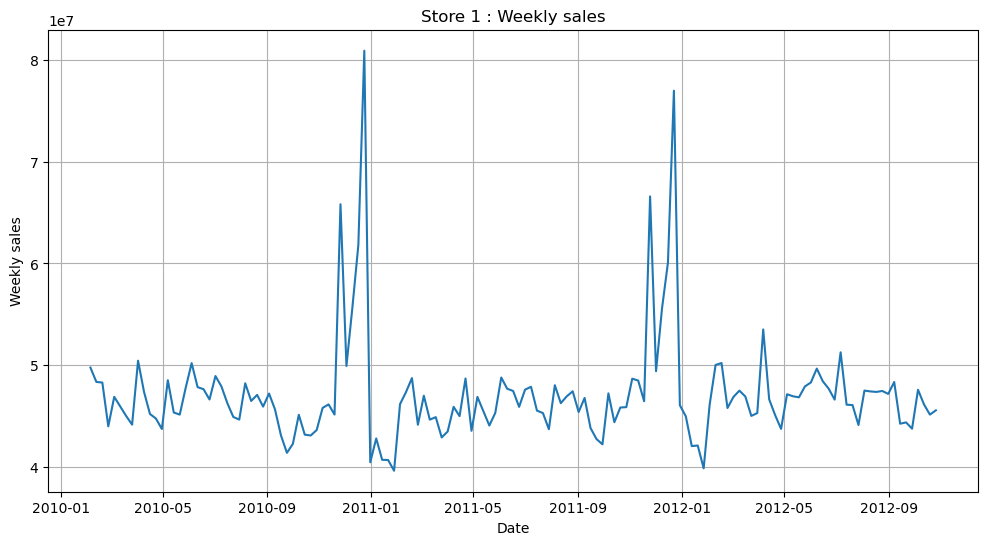

In [16]:
plt.figure(figsize=(12, 6))
plt.plot(store1_df)

plt.title('Store 1 : Weekly sales')
plt.xlabel('Date')
plt.ylabel('Weekly sales')
plt.grid(True);

**Plotting rolling means**

Smoothing can help us see trends in the data. On one graph, plot the following:

- Weekly sales
- The 4-week rolling mean of weekly sales
- The 13-week rolling mean of weekly sales
    - (This is included because there are 13 weeks in a business quarter!)

Make sure the plot has a title, axis labels where appropriate, and a legend.

> **(BONUS)**: Add vertical lines on the plot to indicate January 2011 and January 2012.

In [18]:
store1_df=store1_df.resample('W').mean()

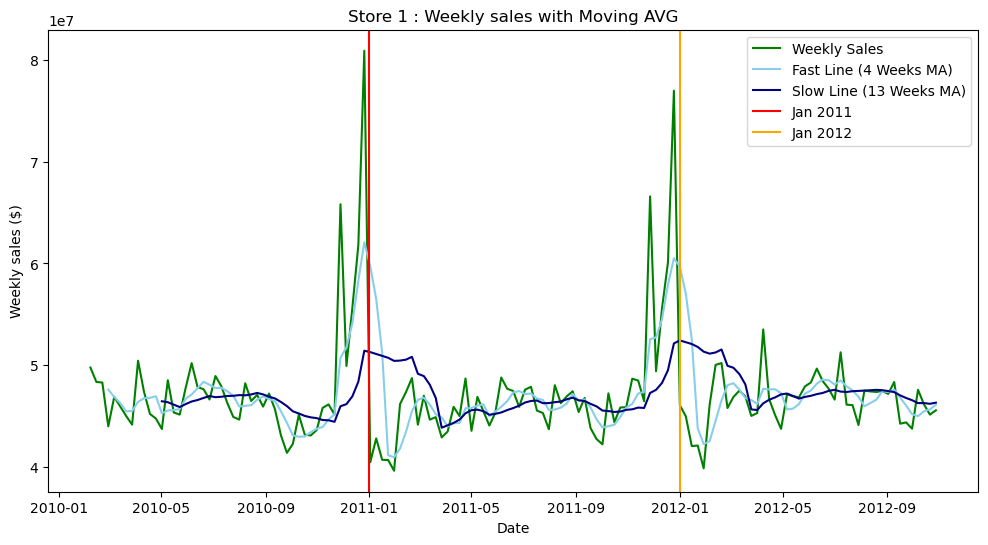

In [19]:
plt.figure(figsize=(12, 6))
plt.plot(store1_df, color='green', label='Weekly Sales')
plt.plot(store1_df.rolling(4).mean(), color='skyblue', label='Fast Line (4 Weeks MA)')
plt.plot(store1_df.rolling(13).mean(), color='navy', label='Slow Line (13 Weeks MA)')


plt.axvline(pd.Timestamp('2011-01-01'), color='red',  label='Jan 2011')
plt.axvline(pd.Timestamp('2012-01-01'), color='orange',  label='Jan 2012')


plt.title('Store 1 : Weekly sales with Moving AVG')
plt.xlabel('Date')
plt.ylabel('Weekly sales ($)')
plt.legend()
plt.show();


**Describe any trends that you notice**

---

### Autocorrelation and partial autocorrelation

Recall that autocorrelation and partial autocorrelation tell us about how a variable is related to itself at previous lags.

**Plot and interpret the autocorrelation**

Use statsmodels to plot the ACF and PACF. Look at up to **52 lags**. 

What do you notice? Provide a written answer along with your ACF/PACF plots below.

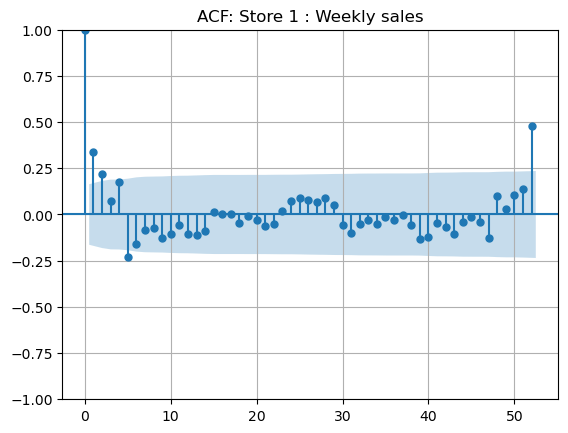

In [22]:
plot_acf(store1_df, lags=52)
plt.title('ACF: Store 1 : Weekly sales')
plt.grid(True)
#Stationarity: ACF show non-significant values (flat lines around zero), the series may already be stationary.

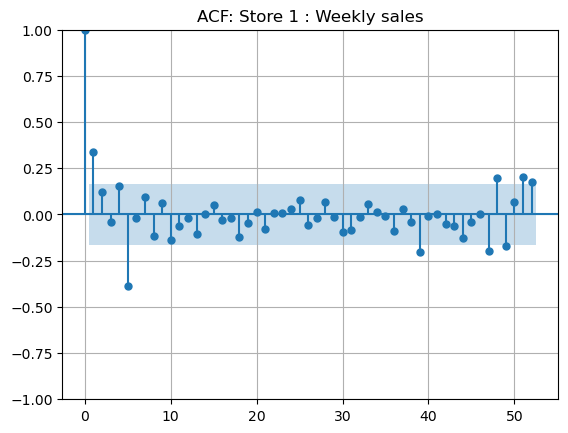

In [23]:
plot_pacf(store1_df, lags=52)
plt.title('ACF: Store 1 : Weekly sales')
plt.grid(True)
#Stationarity: PACF show non-significant values (flat lines around zero), the series may already be stationary.

---

### Modeling

**Train-test splitting**

Before fitting a model, we should train-test split. Use the first 90% of observations as training data, and use the remaining 10% as testing data. Remember -- we **do not need to shuffle the data**!

In [25]:
store1_df.shape

(143, 1)

In [26]:
# 90% mean test size = 0.1
y_train, y_test = train_test_split(store1_df, test_size=0.1, shuffle=False, random_state=123)

In [27]:
y_train.shape, y_test.shape

((128, 1), (15, 1))

**Evaluating stationarity**

Use the augmented Dickey-Fuller test to evaluate the weekly sales data, and interpret the result.

In [29]:
# adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(air.diff().diff().dropna())
adf_statistic, p_value, usedlag, nobs, critical_values, icbest = adfuller(store1_df.diff().diff().dropna())
print('ADF Statistic:', adf_statistic)
print('p-value:', p_value)
# Critical values from Dickey-Fuller distribution tables
print('\nCritical values:')
for key, value in critical_values.items():
   print(f'\t{key}: {value}')

ADF Statistic: -6.945090378068328
p-value: 1.0019746180485878e-09

Critical values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


---

**Fit and evaluate an AR(1) model**

We'll start with a simple autoregressive model with order 1. In statsmodels, an autoregressive model with order $p=1$ can be implemented by instantiating and fitting an ARIMA model with order $(1,0,0)$.

Instantiate and fit your model on the training data.

In [31]:
y_train = y_train.asfreq('W')

model = ARIMA(y_train, order=(1, 0, 0)).fit()

In [32]:
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                  128
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -2165.184
Date:                Thu, 12 Dec 2024   AIC                           4336.368
Time:                        10:15:52   BIC                           4344.924
Sample:                    02-07-2010   HQIC                          4339.844
                         - 07-15-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.723e+07   9.46e+05     49.942      0.000    4.54e+07    4.91e+07
ar.L1          0.3341      0.043      7.819      0.000       0.250       0.418
sigma2        2.9e+13      0.415   6.99e+13      0.000     2.9e+13     2.9e+13
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               873.87
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               2.85   Skew:                             2.55
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.45e+29. Standard errors may be unstable.
"""

### Evaluating the model

**Store predictions**

Remember that statsmodels ARIMA models generate predictions off of **start** and **end** dates.

Generate and store predictions for the training and testing data.

In [34]:
y_train_pred = model.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_pred = model.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Use the [mean_squared_error](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_squared_error.html) function to identify the MSE on the testing data.

In [36]:
mse=mean_squared_error(y_test, y_test_pred)
mse

3275632194047.781

**Generate a plot of the training data, testing data, train preds, and test preds**

Create a plot showing the training data, testing data, train preds, and test preds. Make sure there are labels and legends.

> **Note**: You'll be making more similar plots. You might consider writing a function to generate your plots!

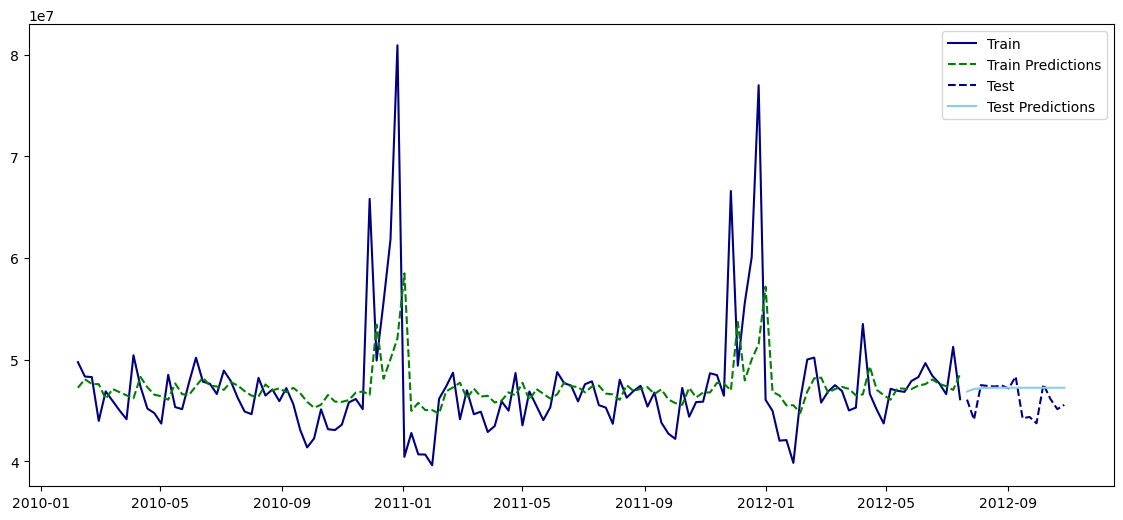

In [38]:

plt.figure(figsize=(14, 6))

plt.plot(y_train, c='navy', label='Train')
plt.plot(y_train_pred, c='green', linestyle='--', label='Train Predictions')
plt.plot(y_test, c='navy', linestyle='--', label='Test')
plt.plot(y_test_pred, c='skyblue', label='Test Predictions')
plt.legend();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [40]:
#It seems poorly performed: test predictions are flat, and the test data drops on 2012-05 and 2012-09.
#model is underfit

---

**Fit and evaluate an ARMA(2,2) model**

In statsmodels, an autoregressive moving average model with order $p=2$, $q=2$ can be implemented by instantiating and fitting an ARIMA model with order $(2,0,2)$.

Instantiate and fit your model on the training data:

In [43]:
model2 = ARIMA(y_train, order=(2, 0, 2)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [45]:
y_train_pred2 = model2.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_pred2 = model2.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE of the testing data.

In [47]:
mse2=mean_squared_error(y_test, y_test_pred2)
mse2

3258435875835.53

**Generate a plot of the training data, testing data, train preds, and test preds**

As before, plot your data and predictions.

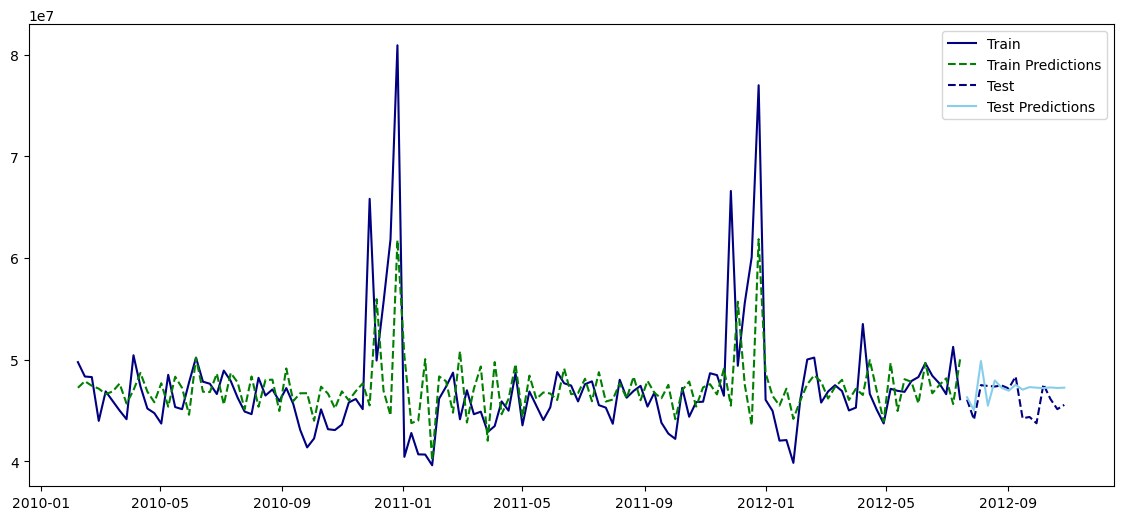

In [49]:

plt.figure(figsize=(14, 6))

plt.plot(y_train, c='navy', label='Train')
plt.plot(y_train_pred2, c='green', linestyle='--', label='Train Predictions')
plt.plot(y_test, c='navy', linestyle='--', label='Test')
plt.plot(y_test_pred2, c='skyblue', label='Test Predictions')
plt.legend();

**Intepretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [51]:
# A: 
#It performed better compared with AR1.
#Test predictions are aligned until 2012-09; the test line drops when the prediction line is flat. 

#model is underfit

---

**Fit and evaluate an ARIMA(2,1,2) model**

Instantiate and fit an ARIMA model with order $(2,1,2)$.

In [53]:
model3 = ARIMA(y_train, order=(2, 1, 2)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [55]:
y_train_pred3 = model3.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_pred3 = model3.predict(start=y_test.index[0], end=y_test.index[-1])


**Mean squared error**

Find the MSE on your testing data.

In [57]:
mse3=mean_squared_error(y_test, y_test_pred3)
mse3

3707185333933.2705

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

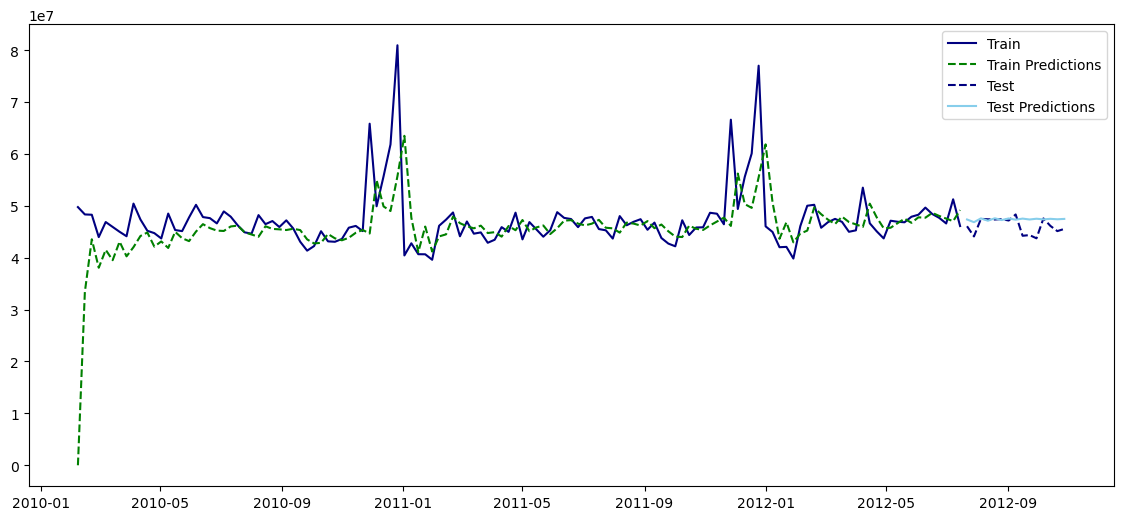

In [59]:

plt.figure(figsize=(14, 6))

plt.plot(y_train, c='navy', label='Train')
plt.plot(y_train_pred3, c='green', linestyle='--', label='Train Predictions')
plt.plot(y_test, c='navy', linestyle='--', label='Test')
plt.plot(y_test_pred3, c='skyblue', label='Test Predictions')
plt.legend();

#### Interpretation:

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [61]:
# A: It still underfitting but it is better when compare with AR1 and AR2 

---

### Fit and evaluate an ARIMA(52,0,1) model

The models above use few autoregressive terms and don't do a good job of capturing the long-term trends that we know exist.

Instantiate and fit an ARIMA of order $(52,0,1)$.

In [63]:
model4 = ARIMA(y_train, order=(52, 0, 1)).fit()

### Evaluating the model

**Store predictions**

Generate and store predictions for train and test.

In [65]:
y_train_pred4 = model4.predict(start=y_train.index[0], end=y_train.index[-1])
y_test_pred4 = model4.predict(start=y_test.index[0], end=y_test.index[-1])

**Mean squared error**

Find the MSE on your testing data.

In [67]:
mse4=mean_squared_error(y_test, y_test_pred4)
mse4

2794520718080.8823

**Generate a plot of the training data, testing data, train preds and test preds**

As before, plot your data and predictions.

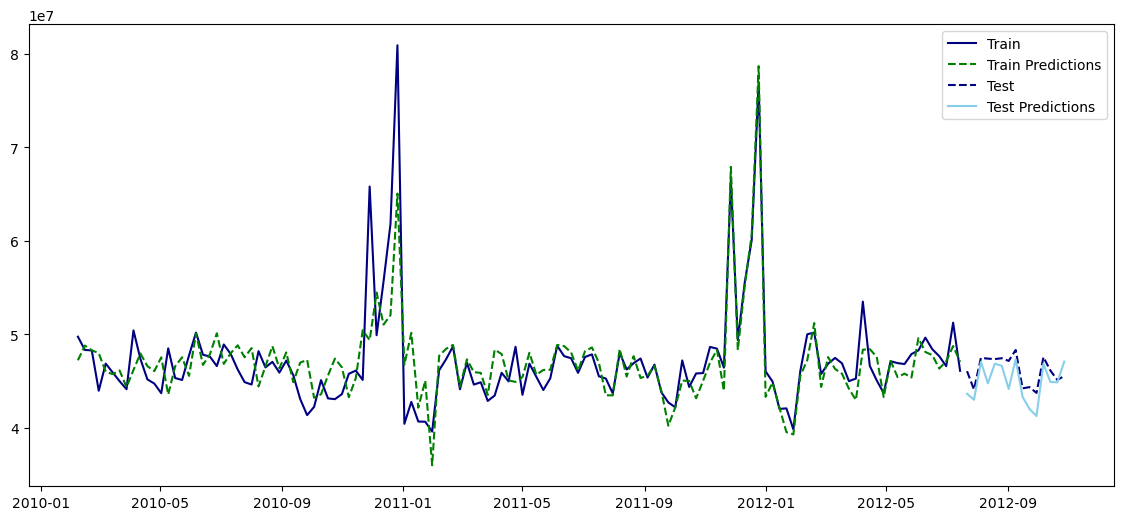

In [69]:

plt.figure(figsize=(14, 6))

plt.plot(y_train, c='navy', label='Train')
plt.plot(y_train_pred4, c='green', linestyle='--', label='Train Predictions')
plt.plot(y_test, c='navy', linestyle='--', label='Test')
plt.plot(y_test_pred4, c='skyblue', label='Test Predictions')
plt.legend();

**Interpretation**

How well or how poorly does the model seem to perform? Provide a brief interpretation.

In [71]:
# A: 
#It well perform model 
#There appears to be some series underestimation 
#The predictions tend to be slightly lower than the actual values in some weeks, particularly during sharp increases 

---

### SARIMA Modeling

Because of the seasonality of this data, a **seasonal** ARIMA model will perform more strongly.

A SARIMA model has an ARIMA portion which behaves as we expect it to. The S part of a SARIMA model allows us to use seasonal terms. The seasonal part of a SARIMA has order $(P, D, Q)_{m}$. $m$ is the **seasonal period** -- the number of observations per season. $P$, $D$, and $Q$ are somewhat similar to the $p$, $d$, and $q$ terms in an ARIMA model, but $P$, $D$, and $Q$ actually backshift by $m$. 

You can read more about SARIMA models here:
- [PennState SARIMA notes](https://online.stat.psu.edu/stat510/lesson/4/4.1)
- [Forecasting: Principles and Practice 3rd ed.](https://otexts.com/fpp3/seasonal-arima.html)

Fit and evaluate a SARIMA model with order $(2,0,2)$ and seasonal order $(1,1,1,52)$. How well does it perform?

> **Note**: SARIMA models are implemented in statsmodels as SARIMAX - the 'X' part allows [exogenous data](https://en.wikipedia.org/wiki/Exogenous_and_endogenous_variables) to be passed in as well, though we won't specify any.
>
> The seasonal order argument is `seasonal_order`.

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


models = SARIMAX(store1_df, order=(2, 0, 2), seasonal_order=(1, 1, 1, 52))
results = models.fit()
fitted_values = results.fittedvalues
models

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14009D+01    |proj g|=  5.35465D+00

At iterate    5    f=  1.02457D+01    |proj g|=  1.58834D+00

At iterate   10    f=  1.01264D+01    |proj g|=  3.29166D-02

At iterate   15    f=  1.01257D+01    |proj g|=  3.67514D-02

At iterate   20    f=  1.01097D+01    |proj g|=  5.82698D-02

At iterate   25    f=  1.00982D+01    |proj g|=  4.33768D-01

At iterate   30    f=  1.00825D+01    |proj g|=  1.44140D-01

At iterate   35    f=  1.00777D+01    |proj g|=  3.45220D-02

At iterate   40    f=  1.00758D+01    |proj g|=  3.10822D-02

At iterate   45    f=  1.00753D+01    |proj g|=  5.99916D-02

At iterate   50    f=  1.00741D+01    |proj g|=  1.90206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

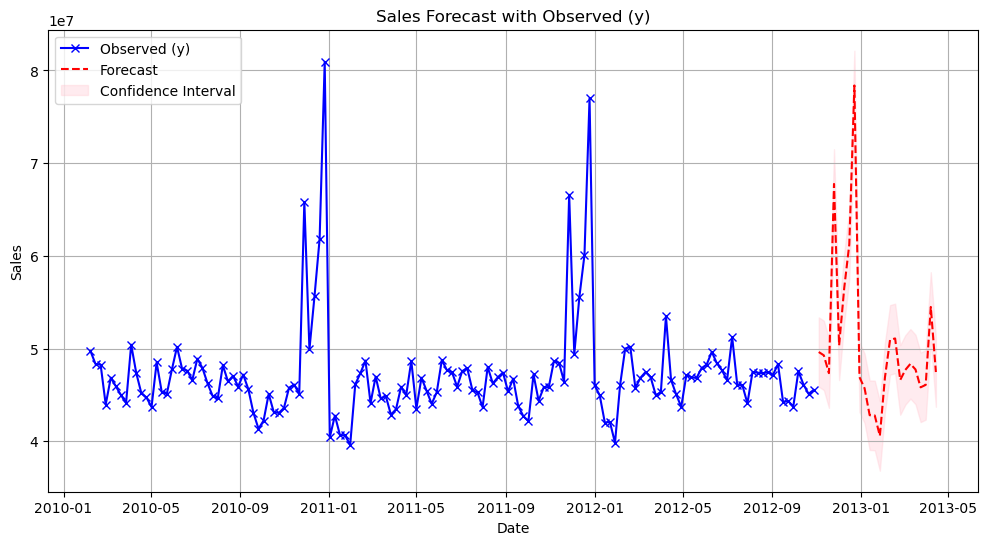

In [74]:
# Forecast future values
forecast_periods = 24  # Forecast the next 24 weeks
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12, 6))
plt.plot(store1_df, label='Observed (y)', color='blue', marker='x', linestyle='-')
plt.plot(forecast_mean, label='Forecast', color='red', linestyle='--')
plt.fill_between(forecast_ci.index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='pink', alpha=0.3, label='Confidence Interval')

plt.title("Sales Forecast with Observed (y)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid()
plt.show()

In [75]:
observed = store1_df[-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 5163588.489152169
MSE: 67155955816475.97
